Experimento baseado no paper:  
# Benchmarking deep network architectures for ethnicity recognition using a new large face dataset  
A. Greco, G. Percannella, M. Vento, and V. Vigilante - Machine Vision and Applications, pp.-, 2020. Online available: https://rdcu.be/b7cX6 

In [1]:
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu))
tf.config.experimental.set_memory_growth(gpu[0], True)
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import os
import numpy as np
from keras import layers
from keras_vggface.vggface import VGGFace
from keras.models import Model
from matplotlib import pyplot as plt
import mtcnn
print(mtcnn.__version__)
import cv2
import sys
from IPython.display import clear_output

TensorFlow version:  2.9.3
GPUs Available:  1
0.1.0


# 3.311.286 Imagens
Originalmente temos a seguinte distribuição:  
169.396 (aprox 5,11%) de teste  
3.141.890 (aprox 94,89%) treino

Porém, em nosso experimento, utilizaremos uma amostragem do dataset (devido a falta de memória :/ ), mantendo a proporção treino/teste, de modo que  
Total = 10.000 (100%)  
Teste = 511 (5,11%)  
Treino = 9.489 (94,89%)  

Vale lembrar que também é importante manter a proporção etnica do dataset em cada conjunto, seja de treino ou teste,  
ou seja, faremos também uma amostragem estratificada mantendo as distribuições étnicas originais do dataset:  

De acordo com o paper, no dataset original (VGG-faces2), no conjunto de teste temos:  


# Etnias (VMER dataset)
1 - Africano Americano  
2 - Asiatico Oriental  
3 - Caucasiano Latino  
4 - Asiatico Indiano  


# Carregando dados étnicos do dataset

In [2]:
Train = ET.parse("F:/VGG-Face2/VMER_dataset/finalTrain.xml")
Test = ET.parse("F:/VGG-Face2/VMER_dataset/finalTest.xml")
trainRoot = Train.getroot()
testRoot = Test.getroot()
trainIDX = []
for subjct in trainRoot.iter('subject'):
    id_element = subjct.find('id')
    ethEl = subjct.find('ethnicity')
    if id_element is not None and ethEl is not None:
        subject_id = id_element.text
        ethnicity = ethEl.text
        trainIDX.append([subject_id,ethnicity])
print(trainIDX)
#Onde trainIDX[i][0] eh o numero do individuo e trainIDX[i][1] eh sua etnia
testIDX = []
for subjct in testRoot.iter('subject'):
    id_element = subjct.find('id')
    ethEl = subjct.find('ethnicity')
    if id_element is not None and ethEl is not None:
        subject_id = id_element.text
        ethnicity = ethEl.text
        testIDX.append([subject_id,ethnicity])
print(testIDX)
#Onde testIDX[i][0] eh o numero do individuo e testIDX[i][1] eh sua etnia


[['n000002', '3'], ['n000003', '3'], ['n000004', '3'], ['n000005', '3'], ['n000006', '4'], ['n000007', '4'], ['n000008', '3'], ['n000010', '4'], ['n000011', '4'], ['n000012', '3'], ['n000013', '3'], ['n000014', '1'], ['n000015', '1'], ['n000016', '3'], ['n000017', '3'], ['n000018', '3'], ['n000019', '3'], ['n000020', '3'], ['n000021', '3'], ['n000022', '3'], ['n000023', '3'], ['n000024', '3'], ['n000025', '3'], ['n000026', '3'], ['n000027', '4'], ['n000028', '4'], ['n000030', '3'], ['n000031', '3'], ['n000032', '4'], ['n000033', '4'], ['n000034', '1'], ['n000035', '3'], ['n000036', '2'], ['n000037', '3'], ['n000038', '3'], ['n000039', '2'], ['n000041', '3'], ['n000042', '3'], ['n000043', '4'], ['n000044', '3'], ['n000045', '3'], ['n000046', '3'], ['n000047', '3'], ['n000048', '3'], ['n000049', '3'], ['n000050', '3'], ['n000051', '3'], ['n000052', '3'], ['n000053', '3'], ['n000054', '3'], ['n000055', '3'], ['n000056', '2'], ['n000057', '3'], ['n000058', '3'], ['n000059', '3'], ['n000060

# Amostragem estratificada do dataset
### Distribuição presente no paper
     __________________________________
    |XXXXXXXXXXXXXXXXX| train | test   |
    |African American |  7,7% |  6,1%  |
    |East Asian       |  6,0% | 11,1%  |
    |Caucasian Latin  | 79,9% | 77,4%  |
    |Asian Indian     |  6,4% |  5,3%  |
    |__________________________________|

### Imagens do experimento mantendo a proporção
     __________________________________
    |XXXXXXXXXXXXXXXXX| train |  test  |
    |African American |  730  |    32  |
    |East Asian       |  570  |    56  |
    |Caucasian Latin  | 7582  |   395  |
    |Asian Indian     |  607  |    28  |
    |TOTAL            | 9489  |   511  |
    |__________________________________|


In [3]:
trainPath = "F:/VGG-Face2/data/vggface2_train/train"
x_train = []
y_train = []
caucasianCount = 0
afroCount = 0
asianCount = 0
indianCount = 0
for i in range(0, len(trainIDX)):
    trainPath = "F:/VGG-Face2/data/vggface2_train/train/"+str(trainIDX[i][0])
    pessoa = os.listdir(trainPath)
    lista = [file for file in pessoa]
    if(int(trainIDX[i][1]) == 1 and afroCount < 730):
        image = Image.open(trainPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_train.append(img_array)
        y_train.append([1,0,0,0])
        afroCount += 1
        if(afroCount < 730):
            image = Image.open(trainPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_train.append(img_array)
            y_train.append([1,0,0,0])
            afroCount += 1
    elif(int(trainIDX[i][1]) == 2 and asianCount < 570):
        image = Image.open(trainPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_train.append(img_array)
        y_train.append([0,1,0,0])
        asianCount += 1
        if(asianCount < 570):
            image = Image.open(trainPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_train.append(img_array)
            y_train.append([0,1,0,0])
            asianCount += 1
    elif(int(trainIDX[i][1]) == 3 and caucasianCount < 7582):
        image = Image.open(trainPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_train.append(img_array)
        y_train.append([0,0,1,0])
        caucasianCount += 1
        if(caucasianCount < 7582):
            image = Image.open(trainPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_train.append(img_array)
            y_train.append([0,0,1,0])
            caucasianCount += 1
    elif(int(trainIDX[i][1]) == 4 and indianCount < 607):
        image = Image.open(trainPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_train.append(img_array)
        y_train.append([0,0,0,1])
        indianCount += 1
        if(indianCount < 607):
            image = Image.open(trainPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_train.append(img_array)
            y_train.append([0,0,0,1])
            indianCount += 1

In [4]:
#train_tensor = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
X_train = np.array(x_train)
print(X_train.shape)

(9489, 224, 224, 3)


In [5]:
testPath = "F:/VGG-Face2/data/vggface2_test/test"
x_test = []
y_test = []
caucasianCount = 0
afroCount = 0
asianCount = 0
indianCount = 0
for i in range(0, len(testIDX)):
    testPath = "F:/VGG-Face2/data/vggface2_test/test/"+str(testIDX[i][0])
    pessoa = os.listdir(testPath)
    lista = [file for file in pessoa]
    if(int(testIDX[i][1]) == 1 and afroCount < 32):
        image = Image.open(testPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_test.append(img_array)
        y_test.append([1,0,0,0])
        afroCount += 1
        if(afroCount < 32):
            image = Image.open(testPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_test.append(img_array)
            y_test.append([1,0,0,0])
            afroCount += 1
    elif(int(testIDX[i][1]) == 2 and asianCount < 56):
        image = Image.open(testPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_test.append(img_array)
        y_test.append([0,1,0,0])
        asianCount += 1
        if(asianCount < 56):
            image = Image.open(testPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_test.append(img_array)
            y_test.append([0,1,0,0])
            asianCount += 1
    elif(int(testIDX[i][1]) == 3 and caucasianCount < 395):
        image = Image.open(testPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_test.append(img_array)
        y_test.append([0,0,1,0])
        caucasianCount += 1
        if(caucasianCount < 395):
            image = Image.open(testPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_test.append(img_array)
            y_test.append([0,0,1,0])
            caucasianCount += 1
    elif(int(testIDX[i][1]) == 4 and indianCount < 28):
        image = Image.open(testPath+'/'+str(lista[0]))
        image = image.resize((224,224))
        img_array = np.array(image)
        x_test.append(img_array)
        y_test.append([0,0,0,1])
        indianCount += 1
        if(indianCount < 28):
            image = Image.open(testPath+'/'+str(lista[5]))
            image = image.resize((224,224))
            img_array = np.array(image)
            x_test.append(img_array)
            y_test.append([0,0,0,1])
            indianCount += 1

In [6]:
#test_tensor = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
X_test = np.array(x_test)
print(X_test.shape)

(511, 224, 224, 3)


In [7]:
# Based on RESNET50 architecture -> new paper(2017)
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='vggface')
last_layer = vggface.layers[-2].output
x = layers.GlobalAveragePooling2D()(last_layer)

inputs = vggface.inputs
outputs = x
model = Model(inputs, outputs)

model.compile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [8]:
def extract_face(filename, required_size = (224, 224)):
 pixels = plt.imread(filename)
 detector = mtcnn.MTCNN()
 results = detector.detect_faces(pixels)
 x1, y1, width, height = results[0]['box']
 x2, y2 = x1 + width, y1 + height
 face = pixels[y1:y2, x1:x2]
 image = Image.fromarray(face)
 image = image.resize(required_size)
 face_array = np.asarray(image)
 return face_array

9488


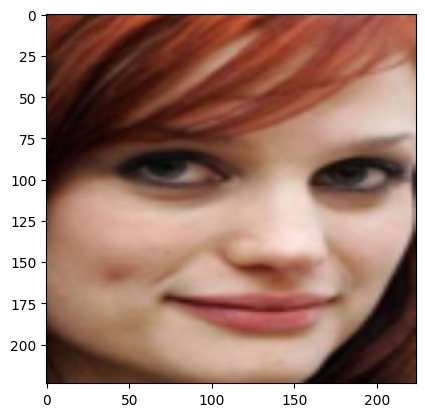

In [9]:
detector = mtcnn.MTCNN()
face_array_train = np.zeros((9489,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 9489):
    results = detector.detect_faces(X_train[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_train[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_train[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_train[i] = X_train[i]

plt.imshow(face_array_train[0])
plt.show()

510


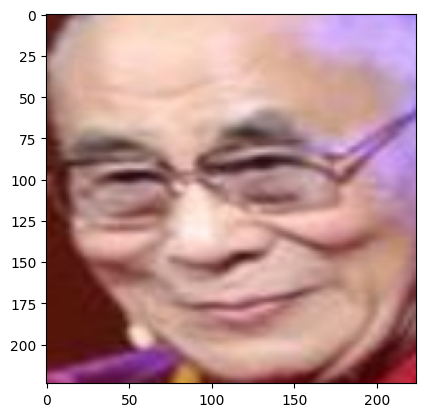

: 

In [10]:
face_array_test = np.zeros((511,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 511):
    results = detector.detect_faces(X_test[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_test[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test[i] = X_test[i]

plt.imshow(face_array_test[0])
plt.show()